In [5]:
!pip install "polars[all]"
!pip install seaborn
!pip install scikit-learn



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: C:\Users\harim\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: C:\Users\harim\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: C:\Users\harim\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
!pip install seaborn



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: C:\Users\harim\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [7]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, f1_score, accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from statistics import mean

import warnings
warnings.filterwarnings("ignore")

sb.set()
pd.set_option('display.max_columns', None)

In [8]:
import os, datetime
import numpy as np
import polars as pl
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
import pandas as pd

# Settings
work_dir = "C:\\Users\\harim\\Downloads\\Hackathon"

ret_var = "stock_ret"
start_date = datetime.date(2005, 1, 1)
end_date   = datetime.date(2026, 1, 1)

print("Imports and settings loaded at", datetime.datetime.now())


Imports and settings loaded at 2025-10-02 16:27:56.094569


In [9]:
fac_path = os.path.join(work_dir, "factor_char_list.csv")
stock_vars = pl.read_csv(fac_path)["variable"].to_list()
print("Loaded predictors:", len(stock_vars))
print(stock_vars[:10])  # preview first 10


Loaded predictors: 147
['age', 'aliq_at', 'aliq_mat', 'ami_126d', 'at_be', 'at_gr1', 'at_me', 'at_turnover', 'be_gr1a', 'be_me']


In [10]:
csv_path = os.path.join(work_dir, "ret_sample.csv")
raw = pl.read_csv(
    csv_path,
    try_parse_dates=True,
    schema_overrides={
        **{v: pl.Float32 for v in stock_vars},  # predictors as floats
        "gvkey": pl.Utf8, "iid": pl.Utf8, "id": pl.Utf8,
    },
    low_memory=True,
    rechunk=True,
)

# Add predictor date (char_date as YYYYMMDD -> pl.Date)
raw = raw.with_columns(
    pl.col("char_date").cast(pl.Utf8).str.strptime(pl.Date, "%Y%m%d").alias("date")
)

raw = raw.filter(pl.col(ret_var).is_not_null())
print("Raw shape:", raw.shape)
print(raw.select(["date", "ret_eom", ret_var]).head(5))


Raw shape: (6401414, 159)
shape: (5, 3)
┌────────────┬──────────┬───────────┐
│ date       ┆ ret_eom  ┆ stock_ret │
│ ---        ┆ ---      ┆ ---       │
│ date       ┆ i64      ┆ f64       │
╞════════════╪══════════╪═══════════╡
│ 2005-01-31 ┆ 20050228 ┆ -0.143457 │
│ 2005-01-31 ┆ 20050228 ┆ 0.028077  │
│ 2005-01-31 ┆ 20050228 ┆ -0.168627 │
│ 2005-01-31 ┆ 20050228 ┆ 0.086271  │
│ 2005-01-31 ┆ 20050228 ┆ 0.149056  │
└────────────┴──────────┴───────────┘


In [11]:
def rank_to_unit(df: pl.DataFrame) -> pl.DataFrame:
    out = df
    for var in stock_vars:
        median = out[var].median()
        out = out.with_columns(
            pl.when(pl.col(var).is_null()).then(pl.lit(median, dtype=pl.Float32)).otherwise(pl.col(var)).alias(var)
        )
        out = out.with_columns((pl.col(var).rank("dense") - 1).cast(pl.Float32).alias(var))
        maxv = out[var].max()
        if maxv is None or maxv == 0:
            out = out.with_columns(pl.lit(0.0, dtype=pl.Float32).alias(var))
        else:
            out = out.with_columns(((pl.col(var) / pl.lit(maxv, dtype=pl.Float32)) * 2.0 - 1.0).alias(var))
    return out

data = raw.group_by("date", maintain_order=True).map_groups(rank_to_unit)
print("Rank-transformed shape:", data.shape)
print(data.head(5))


Rank-transformed shape: (6401414, 159)
shape: (5, 159)
┌────────────┬────────────┬──────────┬────────┬───┬───────────┬───────────┬────────────┬───────────┐
│ id         ┆ date       ┆ ret_eom  ┆ gvkey  ┆ … ┆ qmj       ┆ qmj_prof  ┆ qmj_growth ┆ qmj_safet │
│ ---        ┆ ---        ┆ ---      ┆ ---    ┆   ┆ ---       ┆ ---       ┆ ---        ┆ y         │
│ str        ┆ date       ┆ i64      ┆ str    ┆   ┆ f32       ┆ f32       ┆ f32        ┆ ---       │
│            ┆            ┆          ┆        ┆   ┆           ┆           ┆            ┆ f32       │
╞════════════╪════════════╪══════════╪════════╪═══╪═══════════╪═══════════╪════════════╪═══════════╡
│ comp_00108 ┆ 2005-01-31 ┆ 20050228 ┆ 001081 ┆ … ┆ -0.875554 ┆ -0.582499 ┆ -0.484126  ┆ -0.595185 │
│ 1_01C      ┆            ┆          ┆        ┆   ┆           ┆           ┆            ┆           │
│ comp_00109 ┆ 2005-01-31 ┆ 20050228 ┆ 001096 ┆ … ┆ -0.416403 ┆ -0.155202 ┆ -0.094292  ┆ -0.286774 │
│ 6_01C      ┆            ┆         

In [15]:
pred_frames = []
counter = 0

max_data_date = data.select(pl.col("date").max()).item()
safe_end = min(end_date, (max_data_date - datetime.timedelta(days=365)))

while (start_date + datetime.timedelta(days=365*(11 + counter))) <= safe_end:
    cutoff = [
        start_date,
        start_date + datetime.timedelta(days=365*(8  + counter)),
        start_date + datetime.timedelta(days=365*(10 + counter)),
        start_date + datetime.timedelta(days=365*(11 + counter)),
    ]
    print("Window", counter, cutoff)

    train = data.filter((pl.col("date") >= cutoff[0]) & (pl.col("date") < cutoff[1]))
    val   = data.filter((pl.col("date") >= cutoff[1]) & (pl.col("date") < cutoff[2]))
    test  = data.filter((pl.col("date") >= cutoff[2]) & (pl.col("date") < cutoff[3]))

    if train.height == 0 or val.height == 0 or test.height == 0:
        print("Empty window, skipping")
        counter += 1
        continue

    # Convert to numpy
    X_train = train.select(stock_vars).to_numpy()
    Y_train = train.select(ret_var).to_numpy().ravel()
    X_val   = val.select(stock_vars).to_numpy()
    Y_val   = val.select(ret_var).to_numpy().ravel()
    X_test  = test.select(stock_vars).to_numpy()
    Y_test  = test.select(ret_var).to_numpy().ravel()

    # Standardize
    scaler = StandardScaler().fit(X_train)
    X_train, X_val, X_test = scaler.transform(X_train), scaler.transform(X_val), scaler.transform(X_test)

    Y_mean = Y_train.mean()
    Y_dm   = Y_train - Y_mean

    reg_pred = test.select(["year", "month", "ret_eom", "id", ret_var]).to_pandas()

    # Models
    reg = LinearRegression(fit_intercept=False).fit(X_train, Y_dm)
    reg_pred["ols"] = reg.predict(X_test) + Y_mean

    # lambdas = np.arange(-4, 4.1, 0.1)
    # val_mse = [mean_squared_error(Y_val, Lasso(alpha=10**p, max_iter=1_000_000, fit_intercept=False).fit(X_train, Y_dm).predict(X_val) + Y_mean) for p in lambdas]
    # best = lambdas[int(np.argmin(val_mse))]
    # reg_pred["lasso"] = Lasso(alpha=10**best, max_iter=1_000_000, fit_intercept=False).fit(X_train, Y_dm).predict(X_test) + Y_mean

    lambdas = np.arange(-1, 8.1, 0.1)
    val_mse = [mean_squared_error(Y_val, Ridge(alpha=(10**p)*0.5, fit_intercept=False).fit(X_train, Y_dm).predict(X_val) + Y_mean) for p in lambdas]
    best = lambdas[int(np.argmin(val_mse))]
    reg_pred["ridge"] = Ridge(alpha=(10**best)*0.5, fit_intercept=False).fit(X_train, Y_dm).predict(X_test) + Y_mean

    # lambdas = np.arange(-4, 4.1, 0.1)
    # val_mse = [mean_squared_error(Y_val, ElasticNet(alpha=10**p, max_iter=1_000_000, fit_intercept=False).fit(X_train, Y_dm).predict(X_val) + Y_mean) for p in lambdas]
    # best = lambdas[int(np.argmin(val_mse))]
    # reg_pred["en"] = ElasticNet(alpha=10**best, max_iter=1_000_000, fit_intercept=False).fit(X_train, Y_dm).predict(X_test) + Y_mean

    pred_frames.append(reg_pred)
    counter += 1

print("Finished backtest loop with", counter, "windows")


Window 0 [datetime.date(2005, 1, 1), datetime.date(2012, 12, 30), datetime.date(2014, 12, 30), datetime.date(2015, 12, 30)]
Window 1 [datetime.date(2005, 1, 1), datetime.date(2013, 12, 30), datetime.date(2015, 12, 30), datetime.date(2016, 12, 29)]
Window 2 [datetime.date(2005, 1, 1), datetime.date(2014, 12, 30), datetime.date(2016, 12, 29), datetime.date(2017, 12, 29)]
Window 3 [datetime.date(2005, 1, 1), datetime.date(2015, 12, 30), datetime.date(2017, 12, 29), datetime.date(2018, 12, 29)]
Window 4 [datetime.date(2005, 1, 1), datetime.date(2016, 12, 29), datetime.date(2018, 12, 29), datetime.date(2019, 12, 29)]
Window 5 [datetime.date(2005, 1, 1), datetime.date(2017, 12, 29), datetime.date(2019, 12, 29), datetime.date(2020, 12, 28)]
Window 6 [datetime.date(2005, 1, 1), datetime.date(2018, 12, 29), datetime.date(2020, 12, 28), datetime.date(2021, 12, 28)]
Window 7 [datetime.date(2005, 1, 1), datetime.date(2019, 12, 29), datetime.date(2021, 12, 28), datetime.date(2022, 12, 28)]
Window 8

In [13]:
print(test.columns)


['id', 'date', 'ret_eom', 'gvkey', 'iid', 'excntry', 'stock_ret', 'year', 'month', 'char_date', 'char_eom', 'me', 'prc', 'market_equity', 'div12m_me', 'chcsho_12m', 'eqnpo_12m', 'ret_1_0', 'ret_3_1', 'ret_6_1', 'ret_9_1', 'ret_12_1', 'ret_12_7', 'ret_60_12', 'seas_1_1an', 'seas_1_1na', 'seas_2_5an', 'seas_2_5na', 'at_gr1', 'sale_gr1', 'capx_gr1', 'inv_gr1', 'debt_gr3', 'sale_gr3', 'capx_gr3', 'inv_gr1a', 'lti_gr1a', 'sti_gr1a', 'coa_gr1a', 'col_gr1a', 'cowc_gr1a', 'ncoa_gr1a', 'ncol_gr1a', 'nncoa_gr1a', 'fnl_gr1a', 'nfna_gr1a', 'tax_gr1a', 'be_gr1a', 'ebit_sale', 'gp_at', 'cop_at', 'ope_be', 'ni_be', 'ebit_bev', 'netis_at', 'eqnetis_at', 'dbnetis_at', 'oaccruals_at', 'oaccruals_ni', 'taccruals_at', 'taccruals_ni', 'noa_at', 'opex_at', 'at_turnover', 'sale_bev', 'rd_sale', 'cash_at', 'sale_emp_gr1', 'emp_gr1', 'ni_inc8q', 'noa_gr1a', 'ppeinv_gr1a', 'lnoa_gr1a', 'capx_gr2', 'saleq_gr1', 'niq_be', 'niq_at', 'niq_be_chg1', 'niq_at_chg1', 'rd5_at', 'dsale_dinv', 'dsale_drec', 'dgp_dsale', '


=== Summary Statistics ===
                     id                        date       ret_eom    gvkey  \
count           6401414                     6401414  6.401414e+06  6400963   
unique            55598                         NaN           NaN    52268   
top     comp_002698_01C                         NaN           NaN   005903   
freq                245                         NaN           NaN      489   
mean                NaN  2015-09-06 08:12:02.526000  2.015299e+07      NaN   
min                 NaN         2005-01-03 00:00:00  2.005023e+07      NaN   
25%                 NaN         2010-06-30 00:00:00  2.010073e+07      NaN   
50%                 NaN         2015-11-30 00:00:00  2.015123e+07      NaN   
75%                 NaN         2020-12-30 00:00:00  2.021013e+07      NaN   
max                 NaN         2025-05-30 00:00:00  2.025063e+07      NaN   
std                 NaN                         NaN  5.939062e+04      NaN   

            iid  excntry     stock_

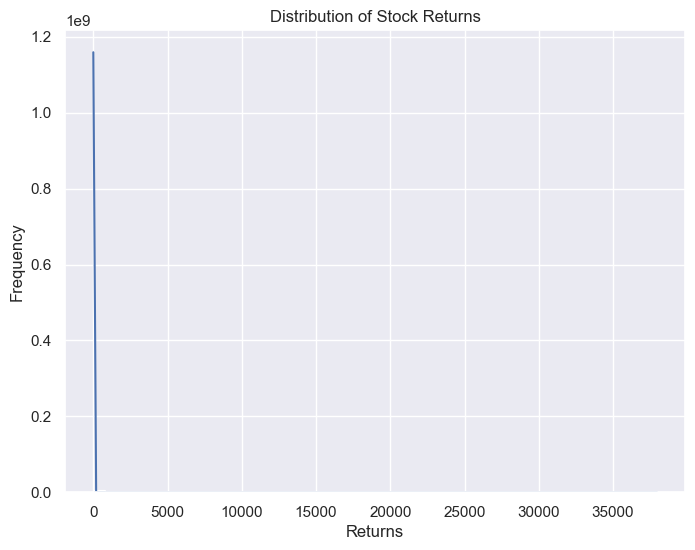

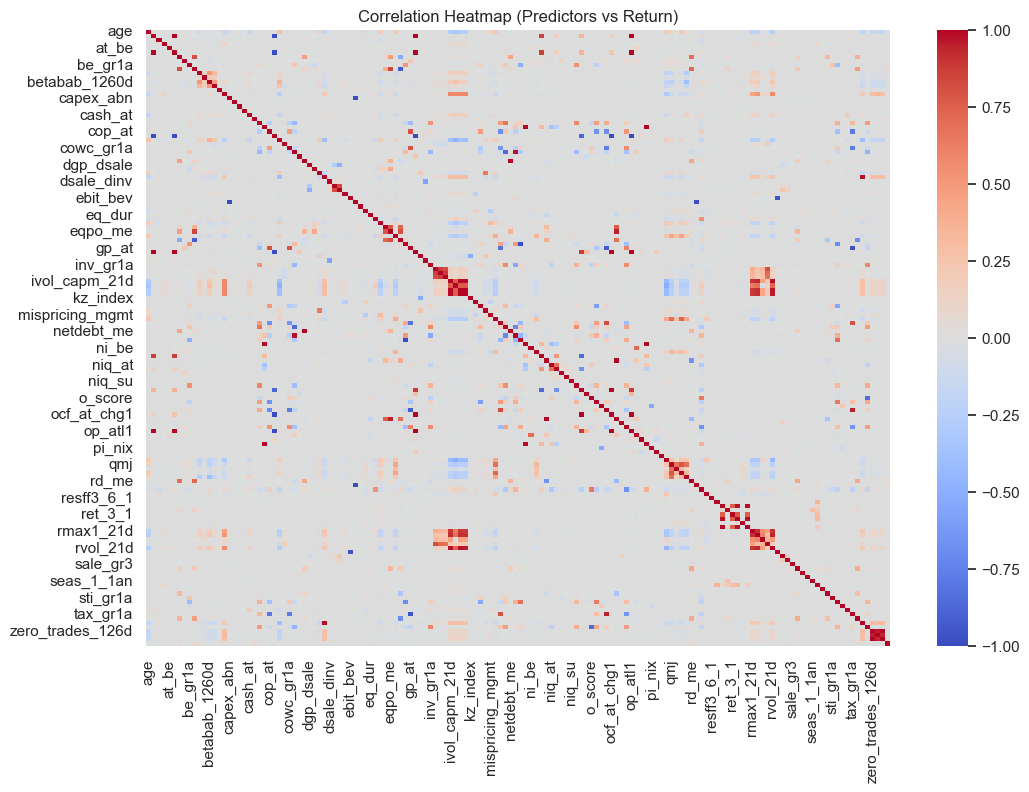


=== Top Predictors Correlated with Return ===
be_me            0.093539
chcsho_12m       0.083105
rd_me            0.080266
at_me            0.049291
fcf_me          -0.034176
ope_be          -0.021331
turnover_126d    0.019567
eqnpo_12m       -0.016152
rd_sale          0.009148
bidaskhl_21d     0.008439
Name: stock_ret, dtype: float64


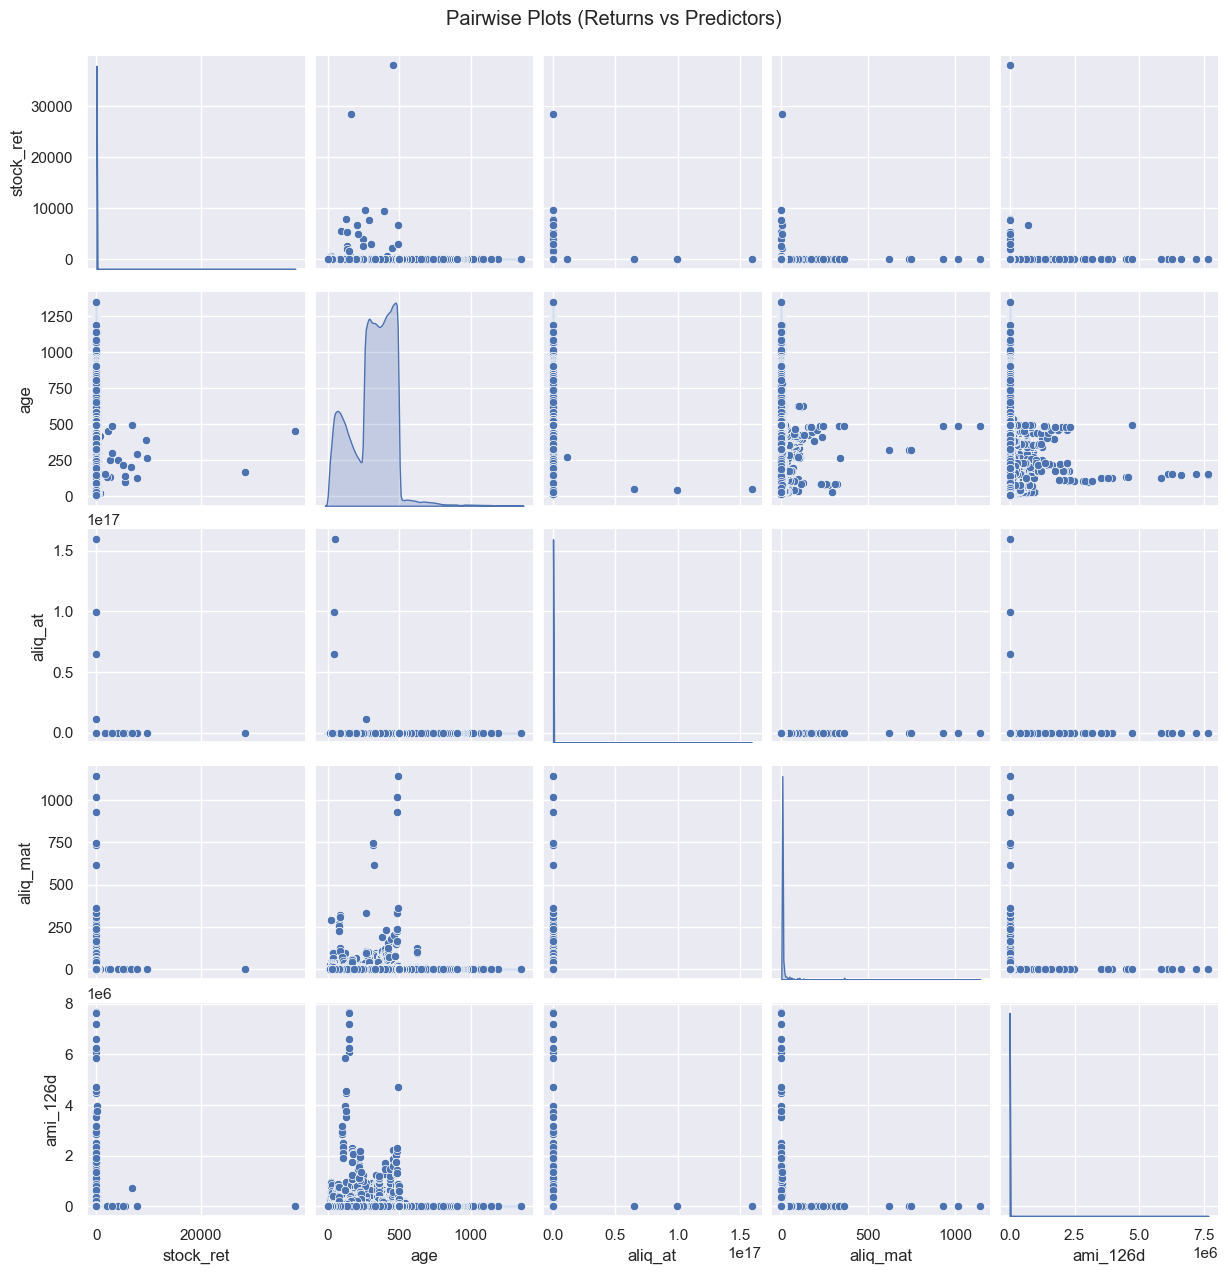

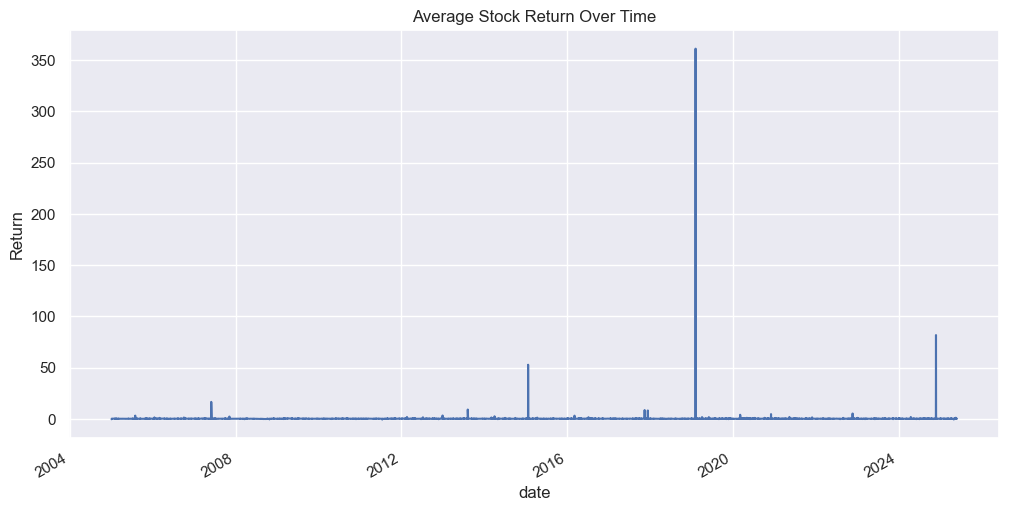

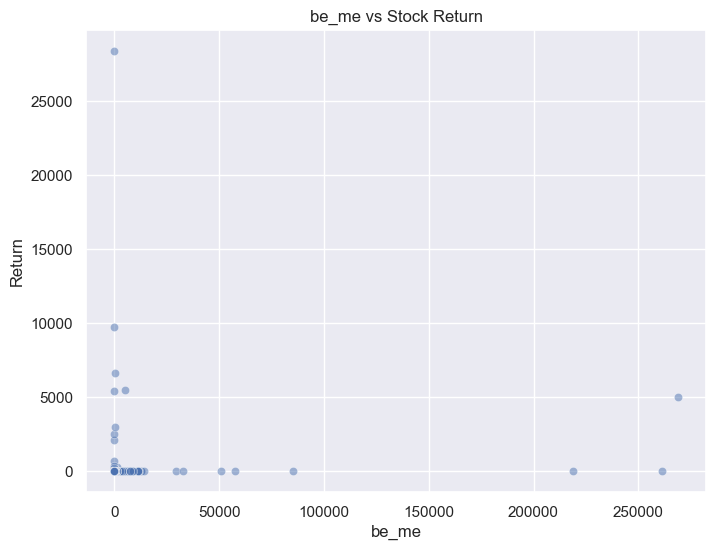

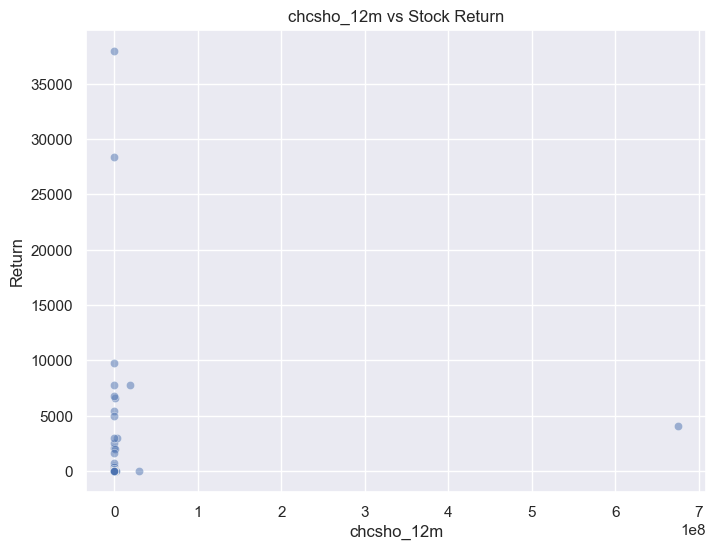

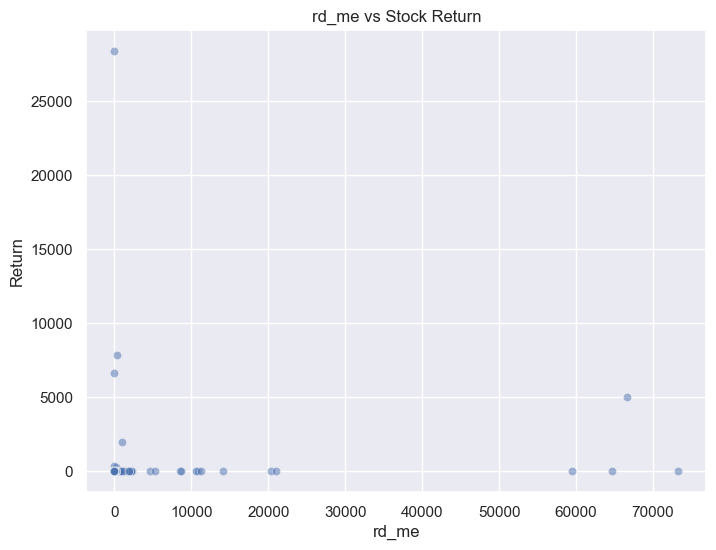

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert Polars DF to Pandas for EDA
df = raw.to_pandas()

# -------------------------------
# 1. Summary Stats
# -------------------------------
print("\n=== Summary Statistics ===")
print(df.describe(include="all"))

print("\n=== Missing Values ===")
print(df.isnull().sum().sort_values(ascending=False))

# -------------------------------
# 2. Distribution of Stock Returns
# -------------------------------
plt.figure(figsize=(8,6))
sns.histplot(df[ret_var], bins=50, kde=True)
plt.title("Distribution of Stock Returns")
plt.xlabel("Returns")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# -------------------------------
# 3. Correlation Heatmap
# -------------------------------
plt.figure(figsize=(12,8))
corr = df[stock_vars + [ret_var]].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Predictors vs Return)")
plt.show()

# -------------------------------
# 4. Top Correlated Predictors
# -------------------------------
corr_with_return = corr[ret_var].drop(ret_var).sort_values(key=abs, ascending=False)
print("\n=== Top Predictors Correlated with Return ===")
print(corr_with_return.head(10))

# -------------------------------
# 5. Pairplot (Predictors vs Return)
# -------------------------------
sns.pairplot(df[[ret_var] + stock_vars[:4]], diag_kind="kde")  # first few vars
plt.suptitle("Pairwise Plots (Returns vs Predictors)", y=1.02)
plt.show()

# -------------------------------
# 6. Time Series of Returns
# -------------------------------
plt.figure(figsize=(12,6))
df.groupby("date")[ret_var].mean().plot()
plt.title("Average Stock Return Over Time")
plt.ylabel("Return")
plt.grid(True)
plt.show()

# -------------------------------
# 7. Scatter Plots for Key Predictors
# -------------------------------
top_vars = corr_with_return.head(3).index.tolist()  # top 3 predictors

for v in top_vars:
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=df[v], y=df[ret_var], alpha=0.5)
    plt.title(f"{v} vs Stock Return")
    plt.xlabel(v)
    plt.ylabel("Return")
    plt.grid(True)
    plt.show()


In [16]:
import pandas as pd
import polars as pl
import numpy as np
import os
import datetime

# Concatenate prediction frames
pred_out = pd.concat(pred_frames, ignore_index=True)

# Save to CSV using polars
pred_out_pl = pl.from_pandas(pred_out)
pred_out_pl.write_csv(os.path.join(work_dir, "output.csv"))
print("Saved to output.csv")

# Convert real values
yreal = pred_out[ret_var].to_numpy()

# Models to check
all_models = ["ols", "lasso", "ridge", "en"]

# Loop through available models safely
for name in all_models:
    if name in pred_out.columns:
        ypred = pred_out[name].to_numpy()
        r2 = 1 - np.sum((yreal - ypred) ** 2) / np.sum(yreal ** 2)
        print(name, r2)
    else:
        print(f"Skipping '{name}' – not found in columns")

# Print current datetime
print(datetime.datetime.now())


Saved to output.csv
ols 1.7212947356348707e-06
Skipping 'lasso' – not found in columns
ridge 2.9143392775710097e-06
Skipping 'en' – not found in columns
2025-10-02 20:56:17.985045


In [19]:
import polars as pl

# Compute correlation of each predictor with stock return
corrs = []
for v in stock_vars:
    try:
        corr_val = raw.select(pl.corr(pl.col(v), pl.col(ret_var))).item()
        corrs.append((v, corr_val))
    except Exception:
        # in case of constant/null column
        corrs.append((v, None))

# Create dataframe of correlations
corr_df = pl.DataFrame(corrs, schema=["predictor", "correlation"])

# Drop nulls and sort by absolute correlation
corr_df = (
    corr_df.drop_nulls()
           .with_columns((pl.col("correlation").abs()).alias("abs_corr"))
           .sort("abs_corr", descending=True)
)

# Print ranked predictors
print("\n=== Predictors Ranked by Correlation with Returns ===")
for row in corr_df.iter_rows(named=True):
    print(f"{row['predictor']}: corr={row['correlation']:.4f}")



=== Predictors Ranked by Correlation with Returns ===
be_me: corr=0.0935
chcsho_12m: corr=0.0831
rd_me: corr=0.0803
at_me: corr=0.0493
fcf_me: corr=-0.0342
ope_be: corr=-0.0213
turnover_126d: corr=0.0196
eqnpo_12m: corr=-0.0162
rd_sale: corr=0.0091
bidaskhl_21d: corr=0.0084
ami_126d: corr=0.0043
div12m_me: corr=0.0043
debt_me: corr=0.0039
netdebt_me: corr=0.0033
ni_be: corr=-0.0032
ivol_capm_252d: corr=0.0029
sale_me: corr=0.0029
ni_me: corr=-0.0025
corr_1260d: corr=-0.0023
rd5_at: corr=0.0023
ope_bel1: corr=-0.0022
ocfq_saleq_std: corr=0.0018
ivol_hxz4_21d: corr=0.0015
ivol_ff3_21d: corr=0.0015
ivol_capm_21d: corr=0.0015
f_score: corr=-0.0014
rvol_21d: corr=0.0014
qmj: corr=-0.0013
taccruals_at: corr=0.0013
qmj_prof: corr=-0.0013
qmj_safety: corr=-0.0013
prc_highprc_252d: corr=-0.0013
rmax5_21d: corr=0.0013
betadown_252d: corr=-0.0011
dolvol_var_126d: corr=0.0008
betabab_1260d: corr=0.0007
rmax1_21d: corr=0.0007
coskew_21d: corr=0.0006
turnover_var_126d: corr=0.0006
aliq_mat: corr=0.

In [17]:
import matplotlib.pyplot as plt

# Check if "lasso" predictions exist
if "lasso" in pred_out.columns:
    ypred_lasso = pred_out["lasso"].to_numpy()

    # Scatter plot: True vs Predicted
    plt.figure(figsize=(8,6))
    plt.scatter(yreal, ypred_lasso, alpha=0.6, label="Predicted (Lasso)")
    plt.plot([yreal.min(), yreal.max()],
             [yreal.min(), yreal.max()],
             color="red", linestyle="--", label="Perfect Fit")

    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("Lasso Regression: True vs Predicted")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Residual plot
    residuals = yreal - ypred_lasso
    plt.figure(figsize=(8,6))
    plt.scatter(yreal, residuals, alpha=0.6)
    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel("True Values")
    plt.ylabel("Residuals (y - ŷ)")
    plt.title("Lasso Regression Residuals")
    plt.grid(True)
    plt.show()
else:
    print("Column 'lasso' not found in predictions.")


Column 'lasso' not found in predictions.


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import  StandardScaler
scaler=StandardScaler()
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score



In [ ]:
# Lasso analysis consistent with other cells in this notebook
import polars as pl
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Use the project's feature list and target
# stock_vars and ret_var are defined earlier in the notebook
X = data.select(stock_vars).to_numpy()
y = data.select(ret_var).to_numpy().ravel()

# Train-test split (same pattern as other cells)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Demean target (same approach used for OLS / Ridge in the notebook)
y_mean = y_train.mean()
y_train_dm = y_train - y_mean

# Standardize features (fit on train only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Fit Lasso without intercept (consistent with other regressions)
lasso = Lasso(fit_intercept=False, max_iter=1_000_000)
lasso.fit(X_train_scaled, y_train_dm)

# Reconstruct predictions (add back mean)
y_pred = lasso.predict(X_test_scaled) + y_mean

print("Metrics for Lasso (no tuning):")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2 Score:", r2_score(y_test, y_pred))

# Hyperparameter tuning (search over log-scale alphas)
param_grid = {'alpha': [10**p for p in np.arange(-2, 3)]}  # 0.01 .. 100
lasso_cv = GridSearchCV(Lasso(fit_intercept=False, max_iter=1_000_000), param_grid, cv=3, n_jobs=-1)
lasso_cv.fit(X_train_scaled, y_train_dm)

print("Best hyperparameters found by GridSearchCV:", lasso_cv.best_params_)

# Predict with tuned model and add back mean
y_pred2 = lasso_cv.predict(X_test_scaled) + y_mean

print("Metrics for Lasso (tuned):")
print("MAE:", mean_absolute_error(y_test, y_pred2))
print("MSE:", mean_squared_error(y_test, y_pred2))
print("R^2 Score:", r2_score(y_test, y_pred2))

# Extract coefficients from best estimator and map to stock_vars
best = lasso_cv.best_estimator_
coefs = best.coef_  # length should equal len(stock_vars)

print("len(stock_vars) =", len(stock_vars), "len(coefs) =", len(coefs))

non_zero_idx = [i for i, c in enumerate(coefs) if c != 0.0]
filtered_columns = [stock_vars[i] for i in non_zero_idx]
filtered_coefs = [coefs[i] for i in non_zero_idx]

# Create a Polars DataFrame showing selected features & coefficients
df_lasso = pl.DataFrame({
    "feature": filtered_columns,
    "coef": filtered_coefs
})
print(df_lasso)

NameError: name 'data' is not defined